# 🎬 IMDb Movie Data Analysis: A Portfolio Project

Author: (Aditya Agarwal)

Objective: Analyze the "IMDb 5000 Movie Dataset" to uncover insights into what makes a movie successful. We will use pandas for data manipulation, numpy for numerical operations, and matplotlib & seaborn for visualization.

Key Questions:
1. What is the relationship between a movie's budget and its gross revenue (and profit)?
2. How are movie ratings (IMDb scores) distributed?
3. Do different genres (e.g., Drama, Comedy, Action) have different average ratings?
4. Are movies getting longer over time?
5. Who are the most profitable and highest-grossing directors?
6. How do key numerical features (budget, gross, score, etc.) correlate?

In [1]:
# 1) Setup: imports and styles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# 2) Load dataset from your workspace path
csv_path = 'Dataset/movie_metadata.csv'
try:
    df = pd.read_csv(csv_path)
    print('Dataset loaded successfully!')
    print(f'Shape: {df.shape[0]} rows, {df.shape[1]} columns')
except FileNotFoundError:
    print('='*50)
    print(f"ERROR: '{csv_path}' not found.")
    print('Please ensure the CSV exists at the path above.')
    print('='*50)
    df = pd.DataFrame()

Dataset loaded successfully!
Shape: 5043 rows, 28 columns


## Data inspection
We'll peek at the first few rows and info to understand columns and nulls.

In [3]:
if not df.empty:
    display(df.head())
    print()
    print(df.info())
else:
    print('DataFrame is empty; subsequent cells may error out.')

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int6

## Cleaning plan
- Convert 'budget' and 'gross' to numeric (strip $ and commas if present).
- Treat 0 in 'budget'/'gross' as missing (NaN).
- Drop rows missing key analysis columns.
- Remove duplicates by movie_title + director_name + title_year.
- Feature engineering: main_genre (first of pipe-separated), profit = gross - budget.

In [4]:
# Convert budget/gross, handle zeros, dropna on key columns
if not df.empty:
    df_clean = df.copy()
    for col in ['budget','gross']:
        if col in df_clean.columns:
            if df_clean[col].dtype == 'O':
                df_clean[col] = (df_clean[col].astype(str)
                                     .str.replace('$','', regex=False)
                                     .str.replace(',','', regex=False))
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            df_clean[col] = df_clean[col].replace(0, np.nan)
    key_cols = [c for c in ['gross','budget','director_name','genres','runtime','imdb_score','title_year','movie_title'] if c in df_clean.columns]
    df_clean = df_clean.dropna(subset=key_cols)
    print(f"Shape after dropna on key cols: {df_clean.shape}")
else:
    df_clean = df

Shape after dropna on key cols: (3891, 28)


In [5]:
# Remove duplicates
if not df_clean.empty:
    subset_cols = [c for c in ['movie_title','director_name','title_year'] if c in df_clean.columns]
    if subset_cols:
        before = df_clean.shape[0]
        df_clean = df_clean.drop_duplicates(subset=subset_cols)
        after = df_clean.shape[0]
        print(f'Dropped {before-after} duplicate rows')

Dropped 101 duplicate rows


In [ ]:
# Feature engineering
if not df_clean.empty:
    # Ensure a unified runtime column name
    if 'runtime' not in df_clean.columns and 'duration' in df_clean.columns:
        df_clean.rename(columns={'duration': 'runtime'}, inplace=True)

    if 'genres' in df_clean.columns:
        df_clean['main_genre'] = df_clean['genres'].astype(str).str.split('|').str[0]
    else:
        df_clean['main_genre'] = np.nan

    if {'gross','budget'}.issubset(df_clean.columns):
        df_clean['profit'] = df_clean['gross'] - df_clean['budget']

    if 'movie_title' in df_clean.columns:
        df_clean['movie_title'] = df_clean['movie_title'].astype(str).str.strip()

    # Dtypes
    for col in ['title_year']:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce').astype('Int64')

    for col in ['budget','gross','profit','runtime']:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    display(df_clean[[c for c in ['movie_title','title_year','main_genre','budget','gross','profit','imdb_score','runtime'] if c in df_clean.columns]].head())

,movie_title,title_year,main_genre,budget,gross,profit,imdb_score
0,Avatar,2009,Action,237000000.0,760505847.0,523505847.0,7.9
1,Pirates of the Caribbean: At World's End,2007,Action,300000000.0,309404152.0,9404152.0,7.1
2,Spectre,2015,Action,245000000.0,200074175.0,-44925825.0,6.8
3,The Dark Knight Rises,2012,Action,250000000.0,448130642.0,198130642.0,8.5
5,John Carter,2012,Action,263700000.0,73058679.0,-190641321.0,6.6


## Descriptive analysis
- Average movie runtime
- Top 10 highest-grossing directors
- Most common movie genre

In [7]:
if not df_clean.empty:
    # Average runtime
    if 'runtime' in df_clean.columns:
        avg_runtime = df_clean['runtime'].mean()
        print(f'Average movie runtime: {avg_runtime:.2f} minutes')
    # Top highest-grossing directors
    if {'director_name','gross'}.issubset(df_clean.columns):
        top_dir_gross = df_clean.groupby('director_name', as_index=False)['gross'].sum().nlargest(10, 'gross')
        print('Top 10 Highest-Grossing Directors:')
        display(top_dir_gross)
    # Most common genre (explode)
    if 'genres' in df_clean.columns:
        genre_counts = (df_clean.assign(genres_split=df_clean['genres'].astype(str).str.split('|'))
                               .explode('genres_split')['genres_split']
                               .value_counts())
        print('Most common genres:')
        display(genre_counts.head(10))

Top 10 Highest-Grossing Directors:


,director_name,gross
1576,Steven Spielberg,4.114233e+09
1097,Michael Bay,2.195444e+09
1295,Peter Jackson,2.112884e+09
655,James Cameron,1.948126e+09
260,Christopher Nolan,1.813228e+09
547,George Lucas,1.741418e+09
1420,Robert Zemeckis,1.619309e+09
231,Chris Columbus,1.618708e+09
1623,Tim Burton,1.557079e+09
1476,Sam Raimi,1.478116e+09


Most common genres:


genres_split
Drama        1914
Comedy       1492
Thriller     1087
Action        935
Romance       868
Adventure     766
Crime         703
Fantasy       496
Sci-Fi        484
Family        442
Name: count, dtype: int64

## Visualizations
### Budget vs Gross (regplot)

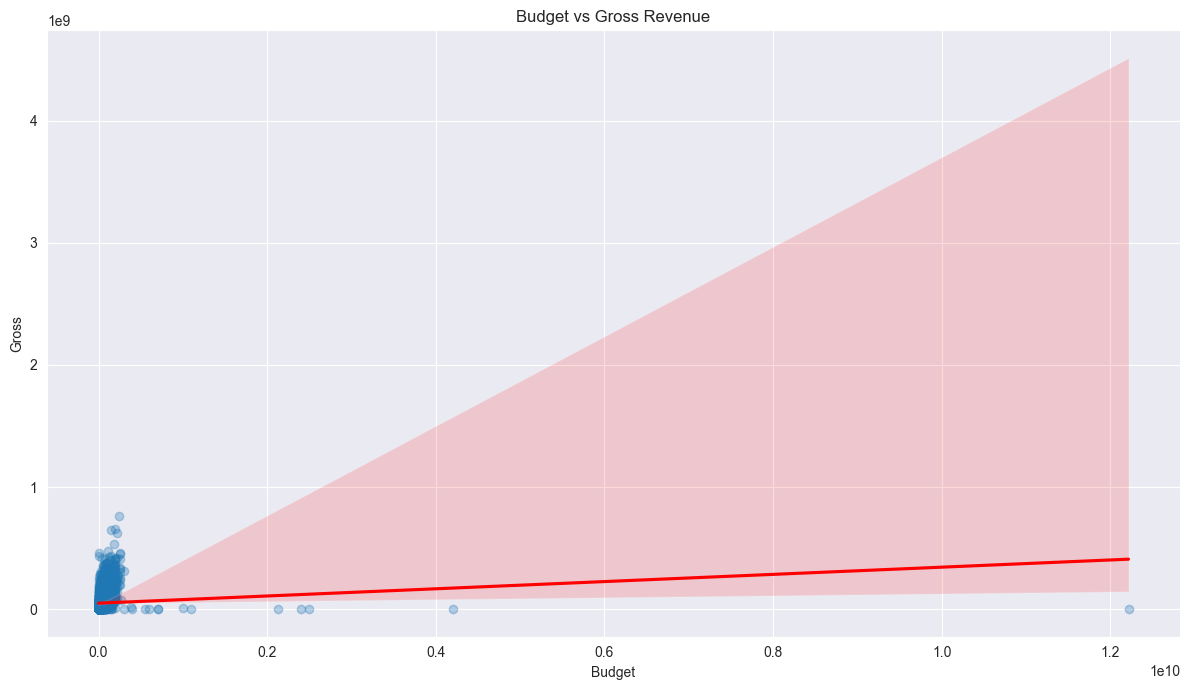

In [8]:
if not df_clean.empty and {'budget','gross'}.issubset(df_clean.columns):
    plt.figure(figsize=(12,7))
    sns.regplot(data=df_clean, x='budget', y='gross', scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    plt.title('Budget vs Gross Revenue')
    plt.xlabel('Budget')
    plt.ylabel('Gross')
    plt.tight_layout()
    plt.show()

### Distribution of IMDb Scores (histplot)

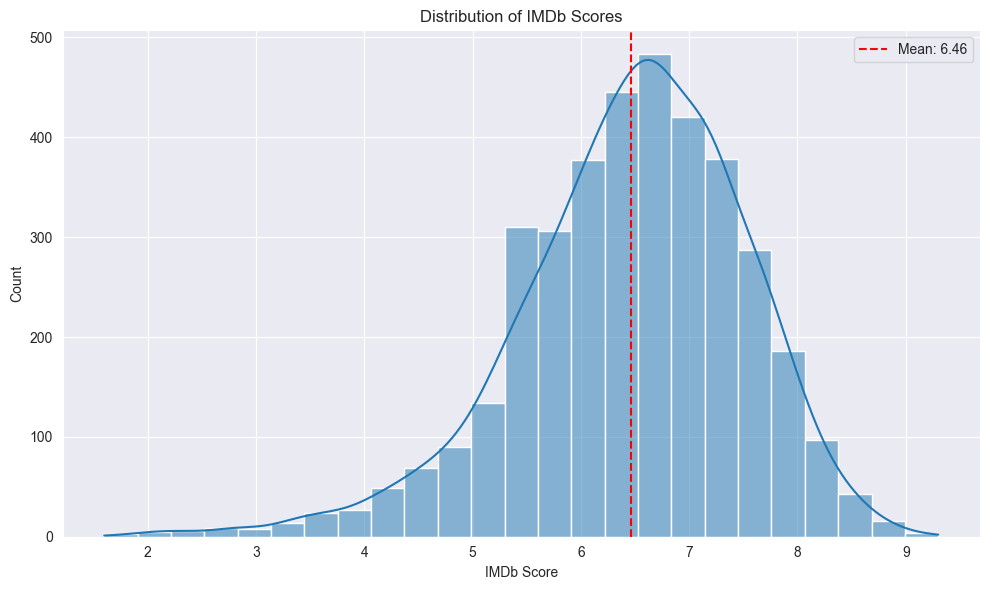

In [9]:
if not df_clean.empty and 'imdb_score' in df_clean.columns:
    plt.figure(figsize=(10,6))
    sns.histplot(df_clean['imdb_score'], bins=25, kde=True)
    mean_score = df_clean['imdb_score'].mean()
    plt.axvline(mean_score, color='red', linestyle='--', label=f'Mean: {mean_score:.2f}')
    plt.title('Distribution of IMDb Scores')
    plt.xlabel('IMDb Score')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()

### Ratings by Main Genre (boxplot)

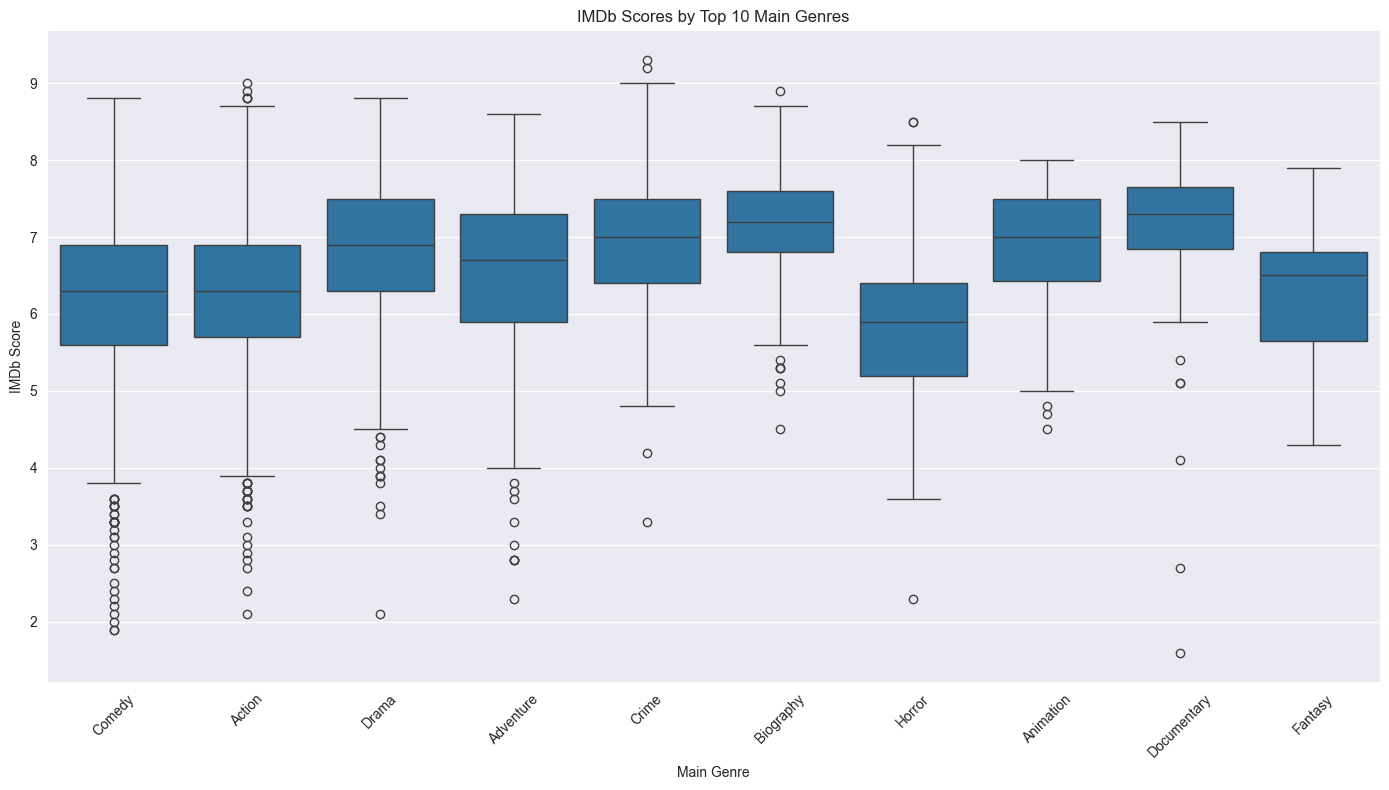

In [10]:
if not df_clean.empty and {'main_genre','imdb_score'}.issubset(df_clean.columns):
    top_genres = df_clean['main_genre'].value_counts().nlargest(10).index
    df_top = df_clean[df_clean['main_genre'].isin(top_genres)]
    plt.figure(figsize=(14,8))
    sns.boxplot(data=df_top, x='main_genre', y='imdb_score', order=top_genres)
    plt.title('IMDb Scores by Top 10 Main Genres')
    plt.xlabel('Main Genre')
    plt.ylabel('IMDb Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Trend of Average Runtime (1980 - Present)

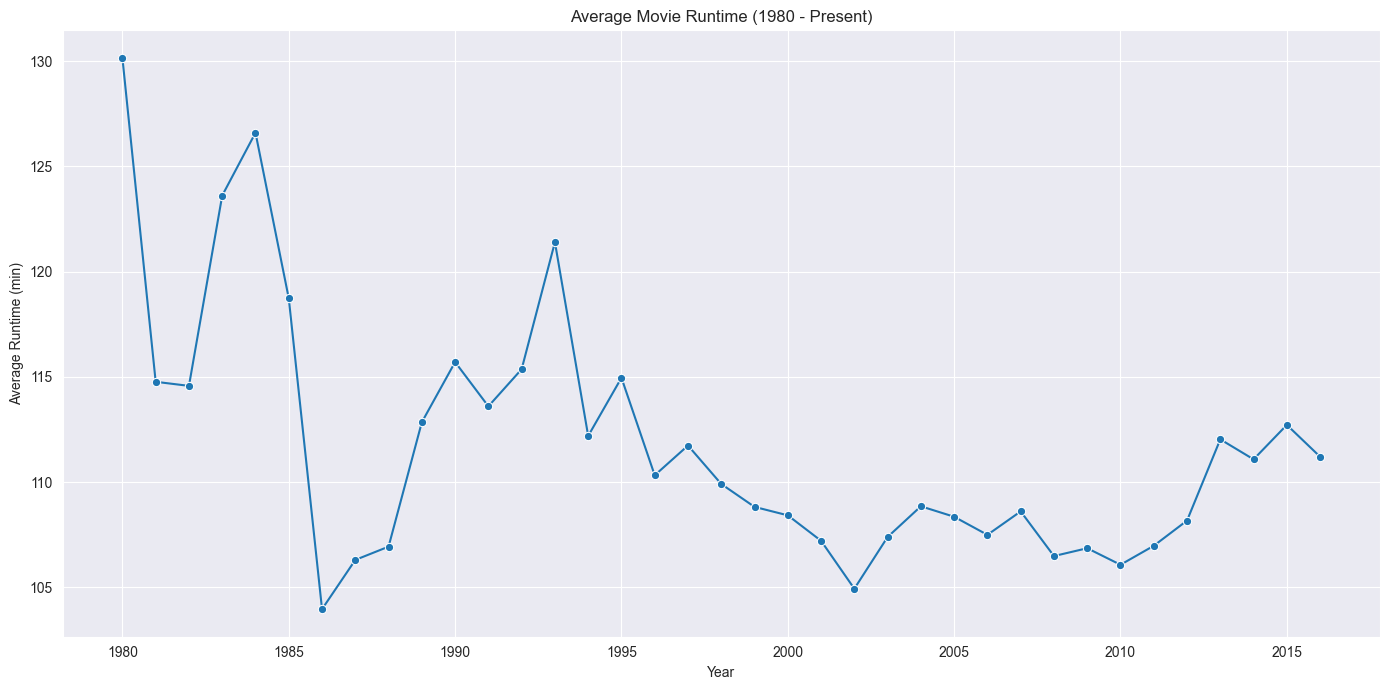

In [21]:
# Robust runtime trend plot (handles 'runtime' or legacy 'duration')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pick the correct runtime column
runtime_col = 'runtime' if 'runtime' in df_clean.columns else ('duration' if 'duration' in df_clean.columns else None)
required_cols = {'title_year'} | ({runtime_col} if runtime_col else set())

if 'df_clean' not in globals() or df_clean is None or df_clean.empty:
    print("df_clean is empty or not defined. Run the cleaning cells above first.")
elif runtime_col is None:
    print("Neither 'runtime' nor 'duration' column exists in df_clean.")
elif not required_cols.issubset(df_clean.columns):
    missing = required_cols.difference(df_clean.columns)
    print(f"Missing required columns in df_clean: {sorted(list(missing))}")
else:
    # Minimal copy and type coercion
    tmp = df_clean[['title_year', runtime_col]].copy()
    tmp['title_year'] = pd.to_numeric(tmp['title_year'], errors='coerce')
    tmp[runtime_col] = pd.to_numeric(tmp[runtime_col], errors='coerce')

    runtime_by_year = (
        tmp.dropna(subset=['title_year', runtime_col])
           .groupby('title_year', as_index=False)[runtime_col]
           .mean()
           .rename(columns={runtime_col: 'runtime'})
    )

    # Filter to 1980+ and sort
    runtime_by_year = runtime_by_year[runtime_by_year['title_year'] >= 1980]
    runtime_by_year = runtime_by_year.sort_values('title_year')

    if runtime_by_year.empty:
        print("No data available for years >= 1980 after cleaning.")
    else:
        plt.figure(figsize=(14, 7))
        sns.lineplot(data=runtime_by_year, x='title_year', y='runtime', marker='o')
        plt.title('Average Movie Runtime (1980 - Present)')
        plt.xlabel('Year')
        plt.ylabel('Average Runtime (min)')
        plt.tight_layout()
        plt.show()

### Top 10 Most Profitable Directors (Total Profit)

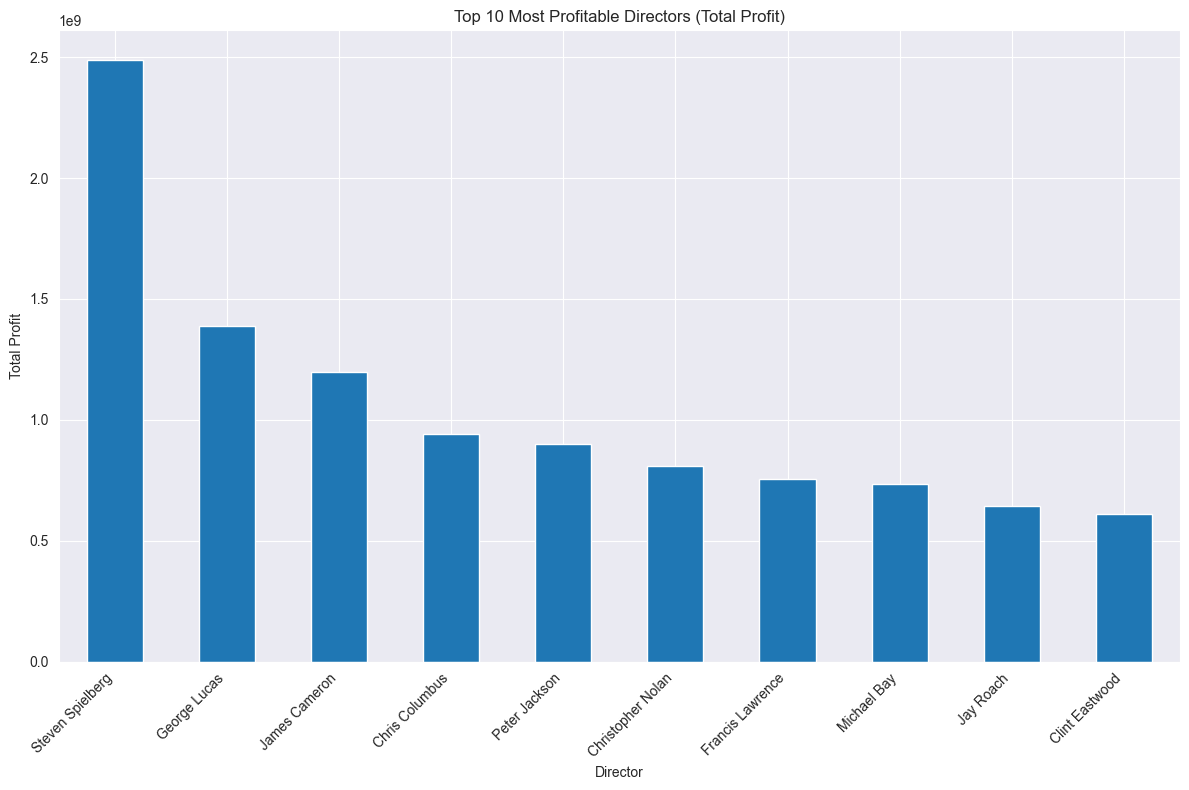

In [12]:
if not df_clean.empty and {'director_name','profit'}.issubset(df_clean.columns):
    top_profit_dir = df_clean.groupby('director_name')['profit'].sum().nlargest(10)
    plt.figure(figsize=(12,8))
    top_profit_dir.sort_values(ascending=False).plot(kind='bar')
    plt.title('Top 10 Most Profitable Directors (Total Profit)')
    plt.xlabel('Director')
    plt.ylabel('Total Profit')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Correlation Heatmap of Key Features

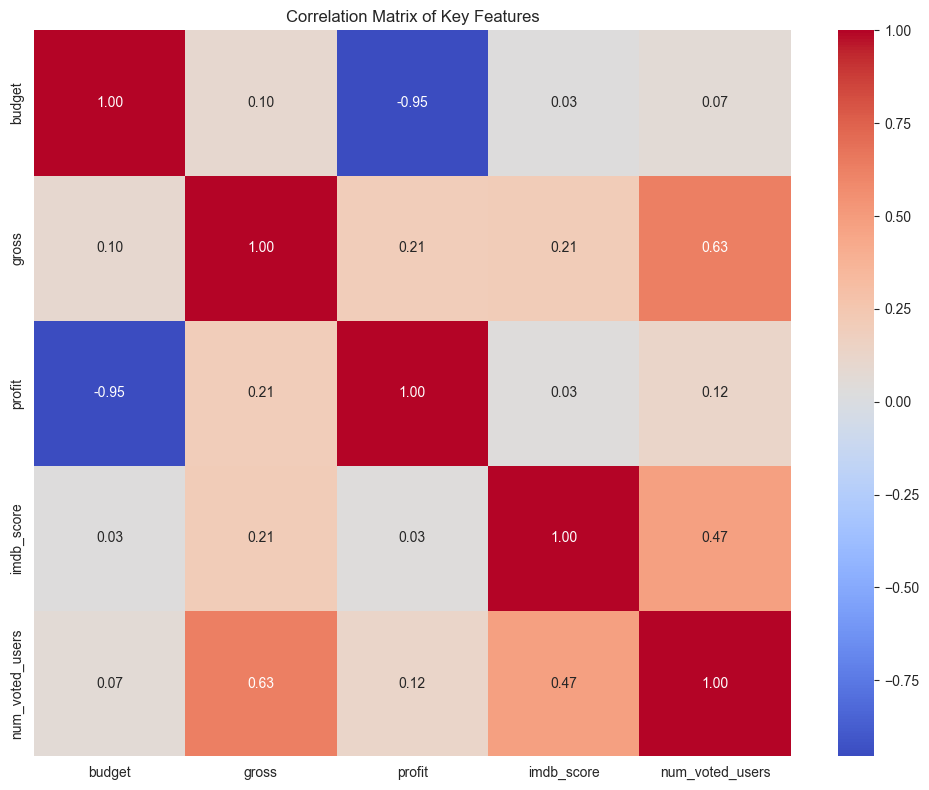

In [13]:
num_cols = [c for c in ['budget','gross','profit','runtime','imdb_score','num_voted_users'] if c in df_clean.columns]
if not df_clean.empty and len(num_cols) >= 2:
    corr = df_clean[num_cols].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Key Features')
    plt.tight_layout()
    plt.show()

## Conclusions
- Budget and gross show a strong positive relationship, with exceptions.
- Ratings cluster between ~6 and 8.
- Genres differ in rating distributions; dramas/biographies often rank higher.
- Average runtimes since 1980 often trend upward.
- A handful of directors dominate in profitability.
- Correlations suggest audience size and gross track together; ratings correlate weakly with gross.